In [1]:
import sys
sys.path.append("..")

import json
import numpy as np

In [2]:
def get_results(filename):
    with open(filename, "r") as f:
        data = json.load(f)
    #print("Number of data points: ", len(data))
    return data

In [3]:
def get_test_data_annotations():
    visual_news_data = json.load(open("../../datasets/visualnews/origin/data.json"))
    visual_news_data_mapping = {ann["id"]: ann for ann in visual_news_data}

    test_data = json.load(open("../../news_clippings/news_clippings/data/merged_balanced/test.json"))
    annotations = test_data["annotations"]
    return annotations
test_data_annotations = get_test_data_annotations()
test_data_annotations = test_data_annotations[:1000]

In [4]:
def fix_unsures(data):
    """
    In instances where one of the models does not have any output, consider the output of the other model to be the truth
    """
    num_unsures = 0
    for i in range(len(data)):
        if data[i]['falsified'] == "Unsure":
            num_unsures += 1
            if data[i]['output']['model_0'] == "" and data[i]['output']['model_1'] != "":
                if "YES" in data[i]['output']['model_1'] or "Yes" in data[i]['output']['model_1']:
                    data[i]['falsified'] = True
                elif "NO" in data[i]['output']['model_1'] or "No" in data[i]['output']['model_1']:
                    data[i]['falsified'] = False
            elif data[i]['output']['model_0'] != "" and data[i]['output']['model_1'] == "":
                if "YES" in data[i]['output']['model_0'] or "Yes" in data[i]['output']['model_0']:
                    data[i]['falsified'] = True
                elif "NO" in data[i]['output']['model_0'] or "No" in data[i]['output']['model_0']:
                    data[i]['falsified'] = False
    print("Num unsures: ", num_unsures)
    return data

In [5]:
def num_disagreements(data):
    """
    Function to check when models actually disagree and when they are just unsure
    """
    disagreements = 0
    for i in range(len(data)):
        m0 = data[i]['output']['model_0']
        m1 = data[i]['output']['model_1']
        if data[i]['falsified'] == "Unsure":
            #check if models disagree
            if ("YES" in m0 or "Yes" in m0) and ("NO" in m1 or "No" in m1 or "Unsure" in m1):
                disagreements += 1
            elif ("NO" in m0 or "No" in m0) and ("YES" in m1 or "Yes" in m1 or "Unsure" in m1):
                disagreements += 1
            elif "Unsure" in m0 and ("YES" in m1 or "NO" in m1 or "Yes" in m1 or "No" in m1):
                disagreements += 1
    print("Num disagreements: ", disagreements)

In [6]:
def get_accuracy(data, annotations):
    num_correct = 0
    data = fix_unsures(data)
    incorrect_idx = []
    for i in range(len(data)):
        if bool(data[i]['falsified']) == annotations[i]['falsified']:
            num_correct += 1
        else:
            incorrect_idx.append(i)
    print("Num incorrects: ", len(incorrect_idx))
    return num_correct/len(data)

In [7]:
def get_incorrect_idx(data, annotations):
    num_correct = 0
    data = fix_unsures(data)
    incorrect_idx = []
    for i in range(len(data)):
        if bool(data[i]['falsified']) != annotations[i]['falsified']:
            incorrect_idx.append(i)
    return incorrect_idx

In [8]:
def get_acc_without_unsures(data, annotations):
    num_correct, num_unsures = 0,0
    for i in range(len(data)):
        if data[i]['falsified'] == 'Unsure':
            num_unsures += 1
        elif bool(data[i]['falsified']) == annotations[i]['falsified']:
            num_correct += 1
    return num_correct/(len(data) - num_unsures)

In [9]:
def true_positives(data, annotations):
    num_tp = 0
    for i in range(len(data)):
        if annotations[i]['falsified'] == True and bool(data[i]['falsified']) == True:
            num_tp += 1
    return num_tp

In [10]:
def false_positives(data, annotations):
    num_fp = 0
    for i in range(len(data)):
        if annotations[i]['falsified'] == False and bool(data[i]['falsified']) == True:
            num_fp += 1
    return num_fp

In [11]:
def false_negatives(data, annotations):
    num_fn = 0
    for i in range(len(data)):
        if annotations[i]['falsified'] == True and bool(data[i]['falsified']) == False:
            num_fn += 1
    return num_fn

In [12]:
def get_precision_and_recall(data, annotations):
    tp,fp,fn = true_positives(data, annotations), false_positives(data, annotations), false_negatives(data, annotations)
    precision = tp/(tp+fp)
    recall = tp/(tp+fn)
    return precision, recall

### no web access

In [180]:
no_web_file = "../results/results_no_web_access.json"
result_data = get_results(no_web_file)
result_data = result_data[:1000]
num_disagreements(result_data)
precision, recall = get_precision_and_recall(result_data, test_data_annotations)
print("Accuracy: {:.4f}".format(get_accuracy(result_data, test_data_annotations)))
print("Precision: {:.4f}".format(precision))
print("Recall: {:.4f}".format(recall))
print("Accuracy without unsures: {:.4f}".format(get_acc_without_unsures(result_data, test_data_annotations)))


Num disagreements:  4
Num unsures:  675
Num incorrects:  428
Accuracy: 0.5720
Precision: 0.5448
Recall: 0.8640
Accuracy without unsures: 0.7515


### with web access (only when model unsure)

In [38]:
web_access_file = "../results/results_web_access_no_initial_context.json"
result_data2 = get_results(web_access_file)
num_disagreements(result_data2)
precision, recall = get_precision_and_recall(result_data2, test_data_annotations)
print("Accuracy: {:.4f}".format(get_accuracy(result_data2, test_data_annotations)))
print("Precision: {:.4f}".format(precision))
print("Recall: {:.4f}".format(recall))
print("Accuracy without unsures: {:.4f}".format(get_acc_without_unsures(result_data2, test_data_annotations)))

Num disagreements:  16
Num unsures:  329
Accuracy: 0.5960
Precision: 0.5804
Recall: 0.6860
Accuracy without unsures: 0.6433


In [41]:
web_access_file = "../results/results_initial_context.json"
result_data3 = get_results(web_access_file)
num_disagreements(result_data3)
precision, recall = get_precision_and_recall(result_data3, test_data_annotations)
print("Accuracy: {:.4f}".format(get_accuracy(result_data3, test_data_annotations)))
print("Precision: {:.4f}".format(precision))
print("Recall: {:.4f}".format(recall))
print("Accuracy without unsures: {:.4f}".format(get_acc_without_unsures(result_data3, test_data_annotations)))

Num disagreements:  7
Num unsures:  9
Accuracy: 0.8580
Precision: 0.8266
Recall: 0.9060
Accuracy without unsures: 0.8587


### with disambiguation queries

In [16]:
web_access_file = "../results/results_with_disambiguation.json"
result_data4 = get_results(web_access_file)
num_disagreements(result_data4)
precision, recall = get_precision_and_recall(result_data4, test_data_annotations)
print("Accuracy: {:.4f}".format(get_accuracy(result_data4, test_data_annotations)))
print("Precision: {:.4f}".format(precision))
print("Recall: {:.4f}".format(recall))
print("Accuracy without unsures: {:.4f}".format(get_acc_without_unsures(result_data4, test_data_annotations)))

Num disagreements:  5
Num unsures:  12
Accuracy: 0.7730
Precision: 0.7468
Recall: 0.8260
Accuracy without unsures: 0.7786


### with opposite stances and disambiguation queries

In [ ]:
web_access_file = "../scripts/temp_final_disamb.json"
result_data5 = get_results(web_access_file)
num_disagreements(result_data5)
precision, recall = get_precision_and_recall(result_data5, test_data_annotations)
print("Accuracy: {:.4f}".format(get_accuracy(result_data5, test_data_annotations)))
print("Precision: {:.4f}".format(precision))
print("Recall: {:.4f}".format(recall))
print("Accuracy without unsures: {:.4f}".format(get_acc_without_unsures(result_data5, test_data_annotations)))

In [24]:
web_access_file = "../scripts/disamb_res_updated_1.json"
result_data5 = get_results(web_access_file)
print(len(result_data5))
num_disagreements(result_data5)
precision, recall = get_precision_and_recall(result_data5, test_data_annotations)
print("Accuracy: {:.4f}".format(get_accuracy(result_data5, test_data_annotations)))
print("Precision: {:.4f}".format(precision))
print("Recall: {:.4f}".format(recall))
print("Accuracy without unsures: {:.4f}".format(get_acc_without_unsures(result_data5, test_data_annotations)))

253
Num disagreements:  1
Num unsures:  6
Accuracy: 0.7352
Precision: 0.7153
Recall: 0.7778
Accuracy without unsures: 0.7368


### actor-skeptic setup

In [15]:
web_access_file = "../results/results_actor_skeptic.json"
result_data6 = get_results(web_access_file)
print(len(result_data6))
#num_disagreements(result_data6)
precision, recall = get_precision_and_recall(result_data6, test_data_annotations)
#print("Accuracy: {:.4f}".format(get_accuracy(result_data6, test_data_annotations)))
print("Precision: {:.4f}".format(precision))
print("Recall: {:.4f}".format(recall))
print("Accuracy without unsures: {:.4f}".format(get_acc_without_unsures(result_data6, test_data_annotations)))

1000
Precision: 0.6610
Recall: 0.6940
Accuracy without unsures: 0.6945


### Finetuned model results

In [18]:
web_access_file = "../results/results_finetuned.json"
result_data7 = get_results(web_access_file)
print(len(result_data7))
num_disagreements(result_data7)
precision, recall = get_precision_and_recall(result_data7, test_data_annotations)
print("Accuracy: {:.4f}".format(get_accuracy(result_data7, test_data_annotations)))
print("Precision: {:.4f}".format(precision))
print("Recall: {:.4f}".format(recall))
print("Accuracy without unsures: {:.4f}".format(get_acc_without_unsures(result_data7, test_data_annotations)))

1000
Num disagreements:  8
Num unsures:  25
Num incorrects:  182
Accuracy: 0.8180
Precision: 0.7449
Recall: 0.9580
Accuracy without unsures: 0.8192


In [19]:
web_access_file = "../results/results_finetuned_debate_refined.json"
result_data7 = get_results(web_access_file)
print(len(result_data7))
num_disagreements(result_data7)
precision, recall = get_precision_and_recall(result_data7, test_data_annotations)
print("Accuracy: {:.4f}".format(get_accuracy(result_data7, test_data_annotations)))
print("Precision: {:.4f}".format(precision))
print("Recall: {:.4f}".format(recall))
print("Accuracy without unsures: {:.4f}".format(get_acc_without_unsures(result_data7, test_data_annotations)))

1000
Num disagreements:  40
Num unsures:  234
Num incorrects:  451
Accuracy: 0.5490
Precision: 0.5180
Recall: 0.9500
Accuracy without unsures: 0.5912


### Analysing where model fails (what kinds of examples the model fails on)

In [20]:
from PIL import Image
from utils.data import get_data, show_data

In [21]:
def retrieve_summary(key):
    with open("../utils/summaries.json", "r") as f:
        data = json.load(f)
    return data[key]

In [22]:
def failed_samples(incorrect_idx, res_data):
    for i in incorrect_idx:
        img, caption, _, annotation = get_data(i)
        display(img)
        show_data(i)
        key = str(annotation['id'])+"_"+str(annotation['image_id'])
        print("Associated summary: ", retrieve_summary(key))
        print("Model_prediction: ", res_data[i]['falsified'])
        print("Model arguments: ", res_data[i]['output'])
        cont = input()
        if "exit" == cont:
            break

Num unsures:  117


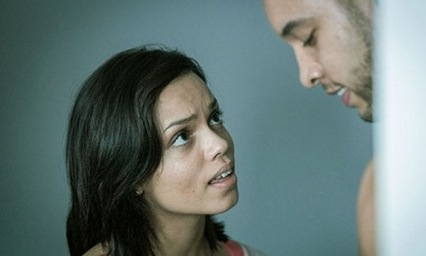

Caption:  BBC3 won the RTS best single drama award for Murdered By My Boyfriend
Misinformation (Ground Truth): False
Associated summary:  SUMMARY:
            
Georgina Campbell won the leading actress award at this year's Bafta television awards for her role in BBC Three's Murdered By My Boyfriend. She beat acclaimed actresses like Sheridan Smith, Keeley Hawes, and Sarah Lancashire for the award. She is now hoping that her win will bring new and exciting projects. She has been cast as the leading lady in Syfy's upcoming Superman prequel series Krypton, playing the role of Lyta Zod, a cadet of the Krypton military who has a forbidden romance with Seg-El, the Man of Steel's grandfather.
Model_prediction:  True
Model arguments:  {'model_0': 'I agree with your assessment that the image-caption pair is misleading because it incorrectly attributes an award to BBC3 when the actual award was won by Georgina Campbell for her role in "Murdered By My Boyfriend." The caption does not accurately r

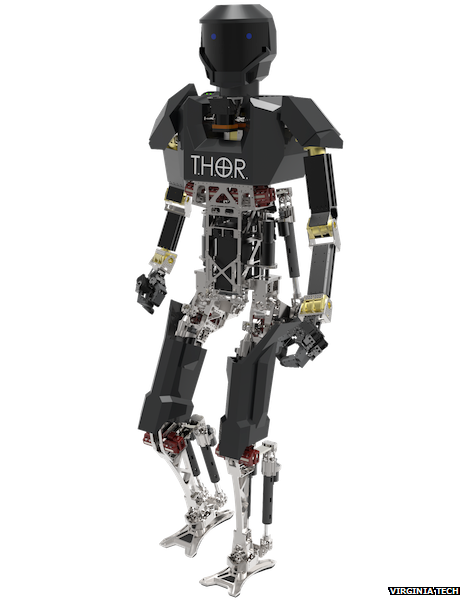

Caption:  Virginia Tech s Thor includes artificial elastic muscles It will not be ready until 2014 so will be replaced by a less advanced substitute at this stage
Misinformation (Ground Truth): False
Associated summary:  SUMMARY:
            
The DARPA Robotics Challenge is an event where teams will compete to develop and test hardware and software for robots to assist humans in emergency response. The challenge will be held over the next two years, with the first virtual challenge event taking place in June 2013. The event will test the robots' ability to perform complex tasks in dangerous, degraded environments.

Boston Dynamics, the firm behind PET-PROTO, a bipedal robot that can climb and jump, will be participating in the challenge. The robot has been designed to perform autonomous decision-making and will be tested on obstacles such as ledges and holes. The video demonstrates the robot's ability to navigate these obstacles with ease.

The challenge will be held in two tracks: Tra

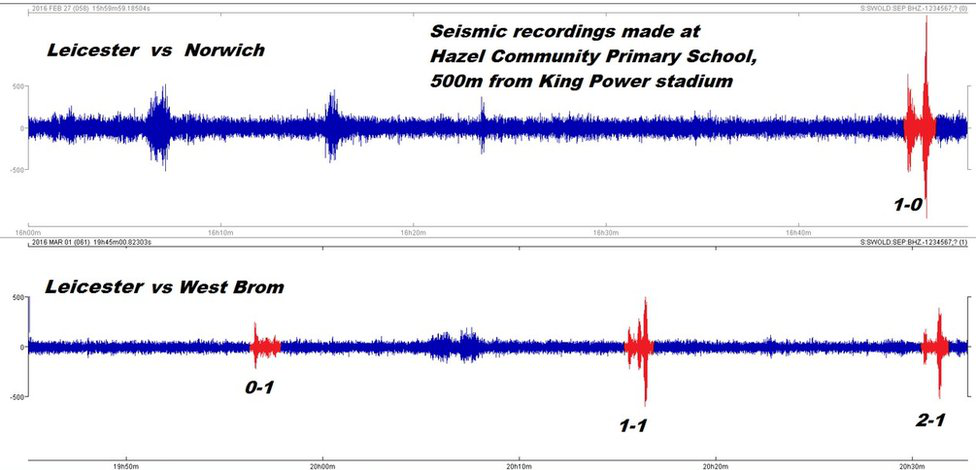

Caption:  Virginia Tech s Thor includes artificial elastic muscles It will not be ready until 2014 so will be replaced by a less advanced substitute at this stage
Misinformation (Ground Truth): True
Associated summary:  SUMMARY:
            
A minor earthquake with a magnitude of 0.3 was recorded in the UK for the first time, attributed to football fans celebrating a goal. The tremor was picked up by seismologists near Leicester City's King Power stadium during a match against Norwich in February. The event has been labeled the "Vardy Quake" after top scorer Jamie Vardy. Geology students at the University of Leicester installed seismic equipment near the stadium and recorded a spike in seismic activity when Leicester scored. The phenomenon is being studied to determine which player will generate the biggest seismic signal. Leicester City is currently leading the Premier League with a five-point advantage.
Model_prediction:  False
Model arguments:  {'model_0': 'not accurately represent 

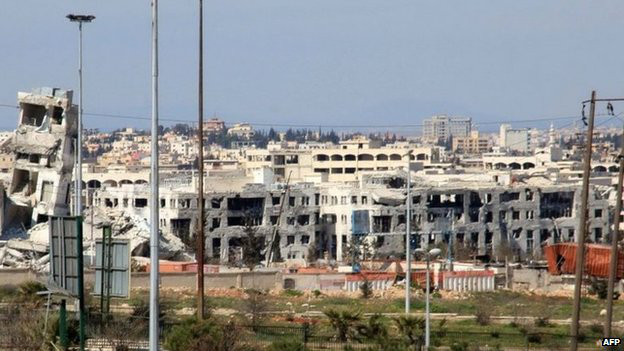

Caption:  Photographs taken on Thursday showed Air Force Intelligence s bombdamaged headquarters in Aleppo
Misinformation (Ground Truth): False
Associated summary:  A bomb attack on a key security headquarters in Aleppo has killed several security forces and rebels. The attack began with a bomb explosion in a tunnel near the headquarters, in the Jamiat al-Zahra area. Al-Qaeda-affiliated Jabhat Nusrat militants and Islamist rebels attacked the headquarters with heavy fire, causing severe damage to the building. The Syrian Air Force, considered one of the most elite forces of the Syrian army, has had a special position since Hafez Assad, the father of current president Bashar Assad, came to power with a military coup. The intelligence and security headquarters in Aleppo is known for its brutality and has been a target of the rebels since two years ago. Experts believe that if the rebels can occupy this headquarters, it will be a significant blow to the government forces and weaken their 

In [23]:
incorrect_idx = get_incorrect_idx(result_data7, test_data_annotations)
#print(incorrect_idx)
failed_samples(incorrect_idx, result_data7)